**Beginning Thought Process for Solution /  Pseudocode:**

I took a look into general information about [sound wave phase](https://dosits.org/science/advanced-topics/phase/) and [audio analysis ](https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520)to understand signal processing. First, I needed to normalize all of the pressure data from the three hydrophones so I could do the Fourier transform. With the phase from the most significant signal, we can find what hydrophone picked up the pinger first, since each will have a different phase. Then, we can determine what general area or range that source is in using the phases. To find the source accurately, we can multiply the fraction of the range by the size of the range to get the degree that the source is at. A model of this is shown below.

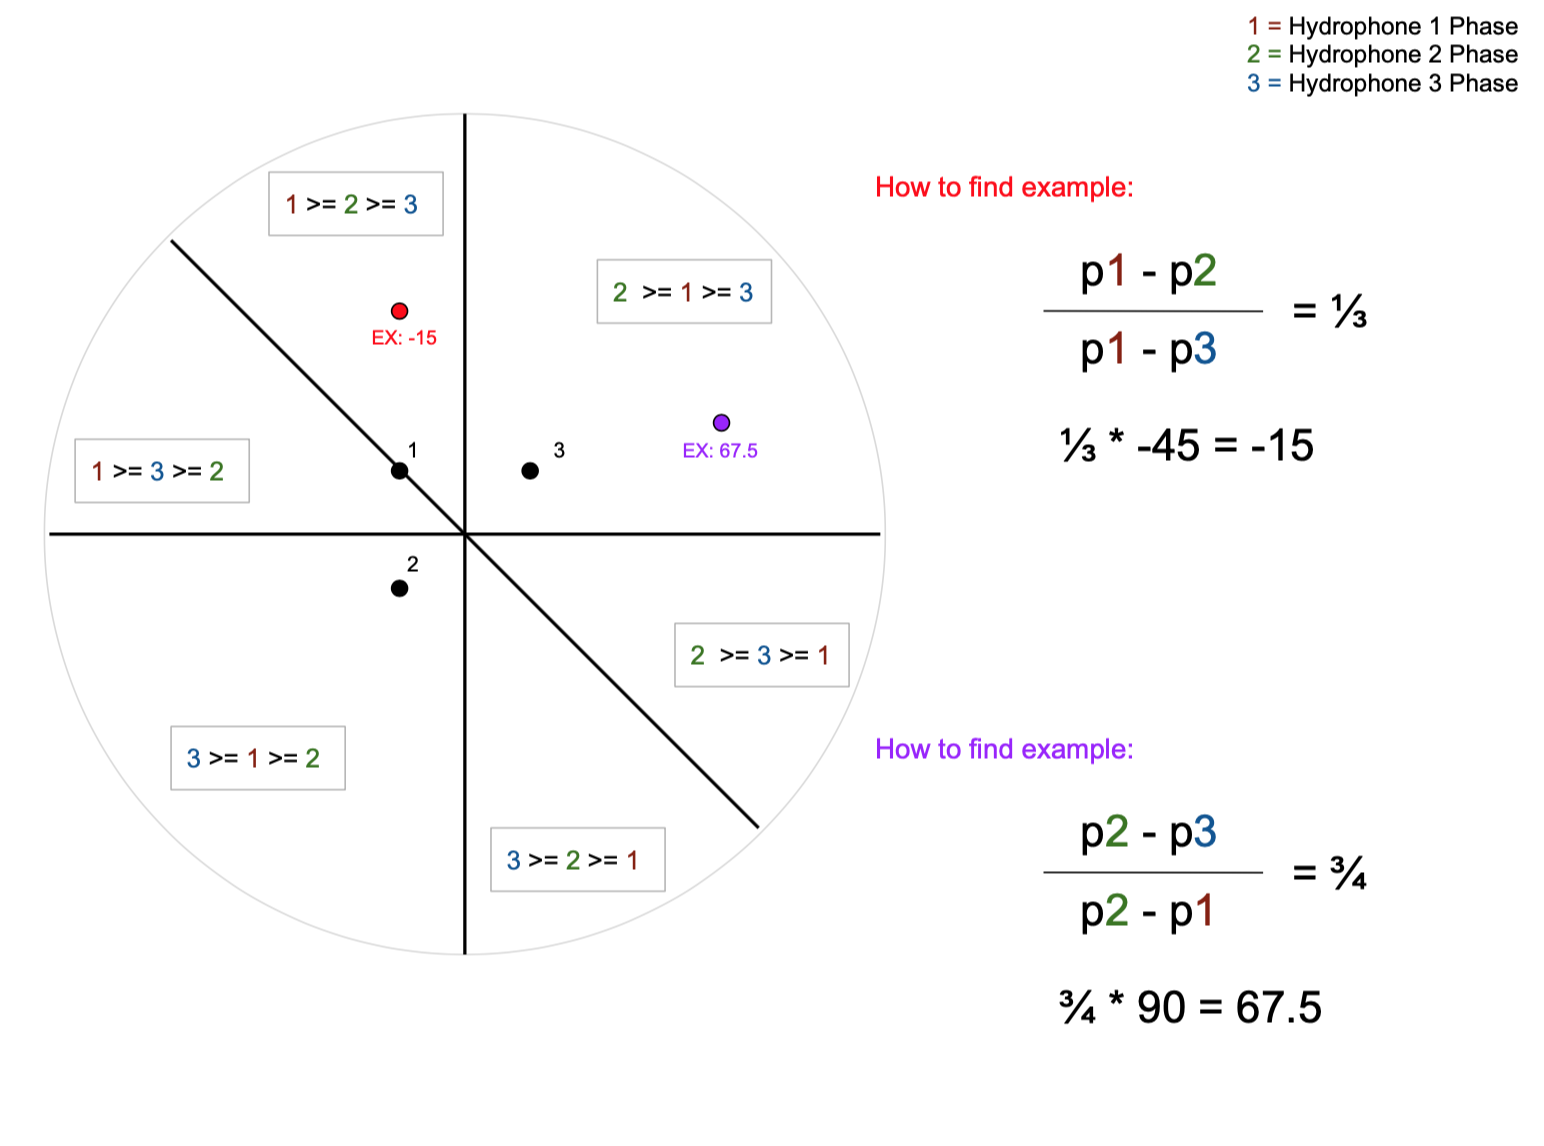

In [2]:
from IPython.display import Image
Image(filename="6_area_model.png")

In [3]:
import numpy as np
import scipy
import math

def signal_process(samples):
    '''normalizes pressure data to [-1, 1] and run fft.'''

    max_value = np.max(samples)
    min_value = np.min(samples)

    mid, halfrange = (max_value + min_value) / 2, (max_value - min_value) / 2  
    normalized = (samples - mid) / halfrange

    return scipy.fft.fft(normalized)


def calc_angle(p1: float, p2: float, p3: float) -> int:
    ''' Calculate angle for each case '''

    if (p1 == p2 == p3):
        raise ValueError(f"Equal phases {p1}")

    # top left upper 45 degree octant
    if p1 >= p2 >= p3:
        result = -45 * (p1 - p2) / (p1 - p3)
    # top left lower 45 degree octant
    elif p1 >= p3 >= p2:
        result = -45 - 45 * (p1 - p3) / (p1 - p2)
    # upper right 90 quadrant
    elif p2 >= p1 >= p3:
        result = 90 * (p2 - p1)/(p2 - p3)
    # bottom right upper 45 degree octant
    elif p2 >= p3 >= p1:
        result = 90 + 45 * (p2 - p3) / (p2 - p1)
    # bottom left 90 quadrant
    elif p3 >= p1 >= p2:
        result = -90 - 90 * (p3 - p1) / (p3 - p2)
    # bottom right lower 45 degree octant
    elif p3 >= p2 >= p1:
        result = 135 + 45 * (p3 - p2) / (p3 - p1)
    
    return int(result)  


def angle_to_pinger(audio_file: str) -> int:

     # Separates into 3 columns for each hydrophone
    raw = np.loadtxt(audio_file, delimiter=';')
    phases = []

    for i in range(3):
        
        # gets index of largest / most significant frequency signal
        fft = signal_process(raw[:, i]) 
        fft_max = np.max(abs(fft))
        index = np.argwhere(abs(fft)[:400] == fft_max)

        # puts phases of each hydrophone into list
        angle = np.angle(fft[index], deg=True)[0][0]
        angle = (angle + 360) % 360
        phases.append(angle) 

    return calc_angle(phases[0], phases[1], phases[2])


def run():
    expected_angles = [-63, 146, -158]

    # Run test cases
    for i in range(len(expected_angles)):
        print (f'Expected output for audio_{i+1}.in: {expected_angles[i]}')
        print (f'Calculated : {angle_to_pinger(f"audios_q3/audio_{i+1}.in.txt")}')
    
run()

Expected output for audio_1.in: -63
Calculated : -67
Expected output for audio_2.in: 146
Calculated : 150
Expected output for audio_3.in: -158
Calculated : -159
